In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import gzip
import os
import copy
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from fashion_mnist.utils.mnist_reader import load_mnist

In [3]:
total_train_image, total_train_labels = load_mnist('./fashion_mnist/data/fashion/', kind='train')
test_image, test_labels = load_mnist('./fashion_mnist/data/fashion/', kind='t10k')

In [4]:
train_image, validation_image = train_test_split(total_train_image, test_size=0.15, random_state=0)
train_labels, validation_labels = train_test_split(total_train_labels, test_size=0.15, random_state=0)

In [5]:
#train_image = np.reshape(train_image,(-1, 28, 28, 1)).astype('float32')
#test_image = np.reshape(test_image,(-1, 28, 28, 1)).astype('float32')

In [6]:
train_labels_onehot = pd.get_dummies(train_labels)
validation_labels_onehot = pd.get_dummies(validation_labels)
test_labels_onehot = pd.get_dummies(test_labels)

In [7]:
def sigmoid_function(z):
    return 1 / (1 + tf.exp(-z))

def loss_function(y, h):
    return tf.reduce_mean((-y * tf.log(h) - (1 - y) * tf.log(1 - h)))

def gradient_update(gradient,h):
    return gradient.assign(tf.tensordot(tf.transpose(X), tf.subtract(h, y),1)/batch)

def theta_update(theta, gradient):
    return theta.assign(theta - lr * gradient)

def pred_y(X,theta):
    return tf.tensordot(X,theta, 1)

def softmax(z):
    exp_num = tf.exp(z)
    sum_div = tf.reduce_sum(exp_num,1, keepdims=True)
    return exp_num / sum_div

In [8]:
lr = 0.01
batch = train_image.shape[0]
epochs = 100
iterations = int(train_image.shape[0]/batch)

In [9]:
test_labels[4]

6

In [10]:
#plt.imshow(test_image[4].reshape(28,28))

In [11]:
X = tf.placeholder(tf.float32, shape =([None,28*28]))
y = tf.placeholder(tf.float32, shape =([None, 10]))

In [12]:
theta = tf.get_variable("theta0", shape=(28*28,10), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [13]:
gradient = tf.get_variable("gradient0", shape=(28*28,10), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [14]:
z = pred_y(X,theta)

In [15]:
h = softmax(z)

In [16]:
loss = loss_function(y,h)

In [17]:
tf_X = tf.placeholder(tf.float32)
tf_X_norm = tf.image.per_image_standardization(tf_X)

In [18]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

train_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: train_image})
validation_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: validation_image})
test_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: test_image})

In [19]:
sess.run(tf.global_variables_initializer())

train_epoch_loss_list = []
validation_epoch_loss_list = []

for i in range(epochs):
    batch_accumulate_loss = 0
    
    print('Epoch {}'.format(i))
    for j in range(iterations):
        index = j*batch

        theta_value = sess.run(theta_update(theta,gradient))
        y_values, h_values, gradient_values, train_loss_value = sess.run([y, h, gradient_update(gradient, h), loss_function(y, h)], feed_dict={X:train_image_norm[index:index+batch], y:train_labels_onehot[index:index+batch]})

        batch_accumulate_loss += train_loss_value

    train_epoch_loss = batch_accumulate_loss/iterations
    train_epoch_loss_list.append(train_epoch_loss)
    validation_loss_value = sess.run(loss, feed_dict={X:validation_image_norm, y:validation_labels_onehot})
    validation_epoch_loss_list.append(validation_loss_value)

    print('Train loss {0:.4f}'.format(train_loss_value))
    print('Validation loss {0:.4f}'.format(validation_loss_value))

Epoch 0
Train loss 0.4641
Validation loss 0.4646
Epoch 1
Train loss 0.4032
Validation loss 0.4041
Epoch 2
Train loss 0.3644
Validation loss 0.3653
Epoch 3
Train loss 0.3346
Validation loss 0.3355
Epoch 4
Train loss 0.3108
Validation loss 0.3117
Epoch 5
Train loss 0.2914
Validation loss 0.2924
Epoch 6
Train loss 0.2753
Validation loss 0.2764
Epoch 7
Train loss 0.2617
Validation loss 0.2629
Epoch 8
Train loss 0.2501
Validation loss 0.2514
Epoch 9
Train loss 0.2401
Validation loss 0.2415
Epoch 10
Train loss 0.2316
Validation loss 0.2330
Epoch 11
Train loss 0.2241
Validation loss 0.2257
Epoch 12
Train loss 0.2177
Validation loss 0.2192
Epoch 13
Train loss 0.2120
Validation loss 0.2136
Epoch 14
Train loss 0.2070
Validation loss 0.2086
Epoch 15
Train loss 0.2025
Validation loss 0.2041
Epoch 16
Train loss 0.1985
Validation loss 0.2001
Epoch 17
Train loss 0.1949
Validation loss 0.1964
Epoch 18
Train loss 0.1915
Validation loss 0.1931
Epoch 19
Train loss 0.1885
Validation loss 0.1900
Epoch 20
T

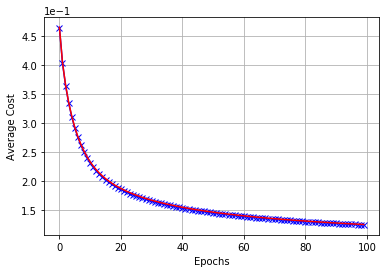

In [20]:
fig = plt.figure(1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.plot(range(len(train_epoch_loss_list)),train_epoch_loss_list, '-bx')
plt.plot(range(len(validation_epoch_loss_list)),validation_epoch_loss_list, '-r')

plt.show()

In [21]:
h_values = sess.run(h, feed_dict={X:test_image_norm})

In [22]:
result_labels = np.zeros_like(h_values,dtype=int)

In [23]:
result_labels[np.arange(len(h_values)), h_values.argmax(1)] = 1

In [24]:
result_labels = np.argmax(result_labels, axis=1)

In [25]:
from sklearn.metrics import f1_score

In [26]:
f1_score(test_labels,result_labels, average='micro')

0.7337

In [27]:
from pandas_ml import ConfusionMatrix

In [28]:
ConfusionMatrix(test_labels,result_labels)

Predicted     0    1    2     3     4     5    6     7    8     9  __all__
Actual                                                                    
0           772    9   13    70    16    28   71     2   18     1     1000
1            40  891    9    36    13     3    7     0    1     0     1000
2            24    3  599    15   183    22  139     0   15     0     1000
3            57   22    1   795    18    19   78     1    9     0     1000
4             7    9  197    51   579    14  131     0   12     0     1000
5             0    0    2     3     0   788    1   117   18    71     1000
6           222    6  137    35   192    51  320     1   35     1     1000
7             0    0    0     0     0    88    0   830    4    78     1000
8             6    2    9    22    21    40   12    17  862     9     1000
9             0    0    0     0     3    39    2    54    1   901     1000
__all__    1128  942  967  1027  1025  1092  761  1022  975  1061    10000